<a href="https://colab.research.google.com/github/ChuhanYang/diminishing_effect_study/blob/main/diminishing_point_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diminishing Point Analysis

By Chuhan Yang, 2025.02.27

**Problem Statement:**

There are three columns in the data table - key, x and y. The graph shows that beyond a certain point a change in x, y reaches a point of diminishing return.

How would you analyze this data and determine diminishing returns using an automated algorithm(aka build prototype)?

Articulate your assumptions, and reasons for picking the point of diminishing return.

**Bonus Points:**

Check if your algorithm is generic enough across the entire data set and show a visual that proves it is generic.  

Add a business context where this kind of problem is applicable

>[Diminishing Point Analysis](#updateTitle=true&folderId=1oBXbHIqrm5sAvfMvNnRR8HMS7_nhWhV5&scrollTo=zpnsynR7I_kF)

>>[Import data & Exploratory analysis](#updateTitle=true&folderId=1oBXbHIqrm5sAvfMvNnRR8HMS7_nhWhV5&scrollTo=DXZri7_BKE3Q)

>>[On diminishing returns phenomenon and point](#updateTitle=true&folderId=1oBXbHIqrm5sAvfMvNnRR8HMS7_nhWhV5&scrollTo=kcqvWVNmTu4M)

>>[Implementing Algorithm](#updateTitle=true&folderId=1oBXbHIqrm5sAvfMvNnRR8HMS7_nhWhV5&scrollTo=qBlTMoZujPVX)

>>[Evaluation of the performance](#updateTitle=true&folderId=1oBXbHIqrm5sAvfMvNnRR8HMS7_nhWhV5&scrollTo=Ppn-tc0bpaCd)

>>>[Computational Performance Evaluation](#updateTitle=true&folderId=1oBXbHIqrm5sAvfMvNnRR8HMS7_nhWhV5&scrollTo=AzcMDb5ugTN4)

>>>[Sensitivity Test](#updateTitle=true&folderId=1oBXbHIqrm5sAvfMvNnRR8HMS7_nhWhV5&scrollTo=El4bZODdgiHG)

>>>[Accuracy/Visual Inspection (Manual validation)](#updateTitle=true&folderId=1oBXbHIqrm5sAvfMvNnRR8HMS7_nhWhV5&scrollTo=aZAgmTwUgtJh)

>>[Some of other ideas & Test](#updateTitle=true&folderId=1oBXbHIqrm5sAvfMvNnRR8HMS7_nhWhV5&scrollTo=KvAf_O0Qnz-d)

>>>[Idea 1: Fitting model with analytical solution](#updateTitle=true&folderId=1oBXbHIqrm5sAvfMvNnRR8HMS7_nhWhV5&scrollTo=XNuT-fOwYjhh)

>>>[Idea 2: find the change point of rate of change](#updateTitle=true&folderId=1oBXbHIqrm5sAvfMvNnRR8HMS7_nhWhV5&scrollTo=Kjx4lJX12ItJ)

>>[Business metric discussion](#updateTitle=true&folderId=1oBXbHIqrm5sAvfMvNnRR8HMS7_nhWhV5&scrollTo=4hADqiGFaOLH)



## Import data & Exploratory analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import seaborn as sns
import time
import memory_profiler
from scipy.optimize import curve_fit

In [ ]:
df_raw = pd.read_excel("magnite_ds_data.xlsx", sheet_name='Data')

print('A sample sanpshot of this data is:\n')
print(df_raw.head())
print('\nA data type summary of this data is:\n')
print(df_raw.info())
print('\nA statistical summary of this data is:\n')
print(df_raw.describe())

print('\nThe number of distinct keys in this data is:\n')
print(df_raw['Key'].nunique())

A sample sanpshot of this data is:

              Key     x      y
0  82353292333796  0.01  46531
1  82353292333796  0.02  15815
2  82353292333796  0.03  11814
3  82353292333796  0.04  15683
4  82353292333796  0.05  12484

A data type summary of this data is:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161681 entries, 0 to 161680
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Key     161681 non-null  int64  
 1   x       161681 non-null  float64
 2   y       161681 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 3.7 MB
None

A statistical summary of this data is:

                Key              x              y
count  1.616810e+05  161681.000000  161681.000000
mean   2.129456e+16       9.195092      24.270372
std    1.484469e+16      18.646770     352.344562
min    8.235329e+13       0.010000       0.000000
25%    3.325879e+15       1.890000       0.000000
50%    3.236335e+16       4.300000       1.

Based on the statistics, some key observations are:
- This dataset contains 161,681 data points and 173 key groups.
- The majority of x-values (75%) are below 10, but a few extremely high values (above 1000) suggest potential outliers.
- Similar spreadout also applis to y-values. Many small values (zero-heavy) with some very large values hints a **highly skewed distribution** (right-skewed).

<ipython-input-3-46533e58a776>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for key, group in df_raw.groupby('key'):


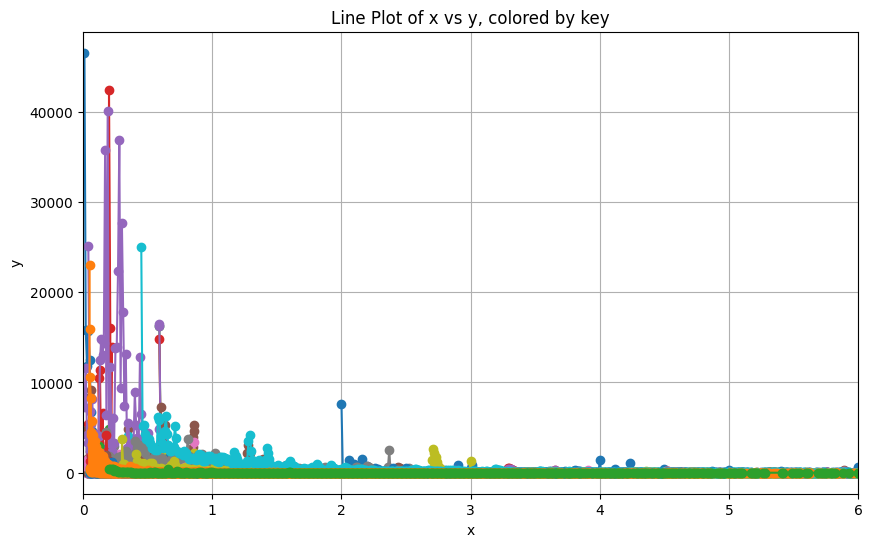

In [ ]:
# General view of the whole dataset (All key groups)
df_raw['key'] = df_raw['Key'].astype('category')

plt.figure(figsize=(10, 6))

for key, group in df_raw.groupby('key'):
    sorted_group = group.sort_values(by='x')
    plt.plot(sorted_group['x'], sorted_group['y'], label=key, marker='o')

plt.xlim(0, 6)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Line Plot of x vs y, colored by key')
#plt.legend(title='Key') # There are 173 distinct keys, hide the color bar for now
plt.grid(True)
plt.show()

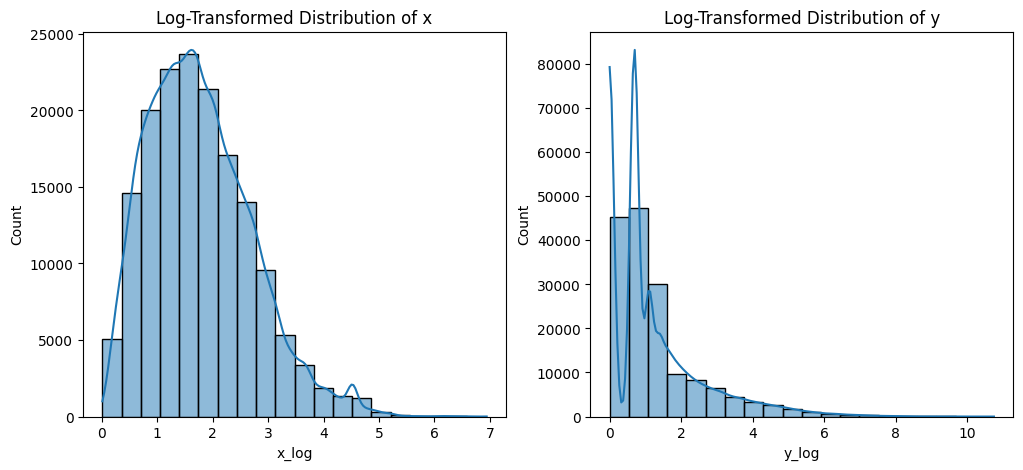

In [ ]:
# the distribution is heavily skewed, apply log transformation
df_raw["x_log"] = np.log1p(df_raw["x"])  # log(1 + x) to handle zero values
df_raw["y_log"] = np.log1p(df_raw["y"])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df_raw["x_log"], bins=20, ax=axes[0], kde=True)
axes[0].set_title("Log-Transformed Distribution of x")

sns.histplot(df_raw["y_log"], bins=20, ax=axes[1], kde=True)
axes[1].set_title("Log-Transformed Distribution of y")

plt.show()

These graphes confirmed the skewed distribution. It's worth considering outliers processing.

In [ ]:
# Check Key-grouyps that have much higher y values
key_summary = df_raw.groupby("Key")["y"].agg(["mean", "max"]).reset_index()
high_y_keys = key_summary[key_summary["max"] > key_summary["max"].quantile(0.99)] # Keys with exceptionally high max y values (above 99th percentile)
print("Keys with exceptionally high y values:")
print(high_y_keys)

Keys with exceptionally high y values:
                 Key        mean    max
0     82353292333796  189.315412  46531
23  3233223738563360  216.014667  42432


However, does this mean we should remove these extreme values? Can we assume these extreme values make no sense at this stage? I believe we still need more external knowledge for further confirmation.

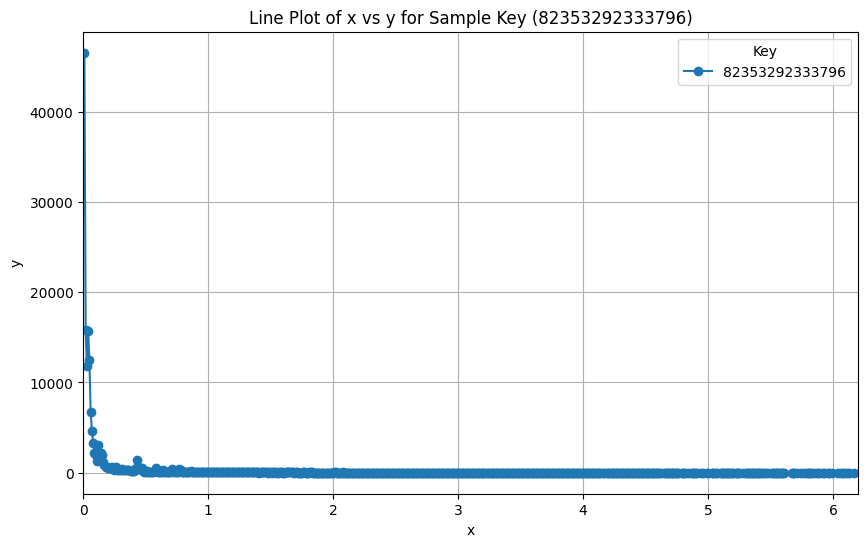

In [ ]:
# Visualize one key group only for clarity (Also recreate the graph from the exmaple as simple data check)
plt.figure(figsize=(10, 6))

filtered_group = df_raw[df_raw['key'] == 82353292333796]
sorted_group = filtered_group.sort_values(by='x')

plt.plot(sorted_group['x'], sorted_group['y'], label='82353292333796', marker='o')

plt.xlim(0, 6.2) # Select xlim 6.2 to match the graph from excel sheet 2.
plt.xlabel('x')
plt.ylabel('y')
plt.title('Line Plot of x vs y for Sample Key (82353292333796)')
plt.legend(title='Key')
plt.grid(True)
plt.show()

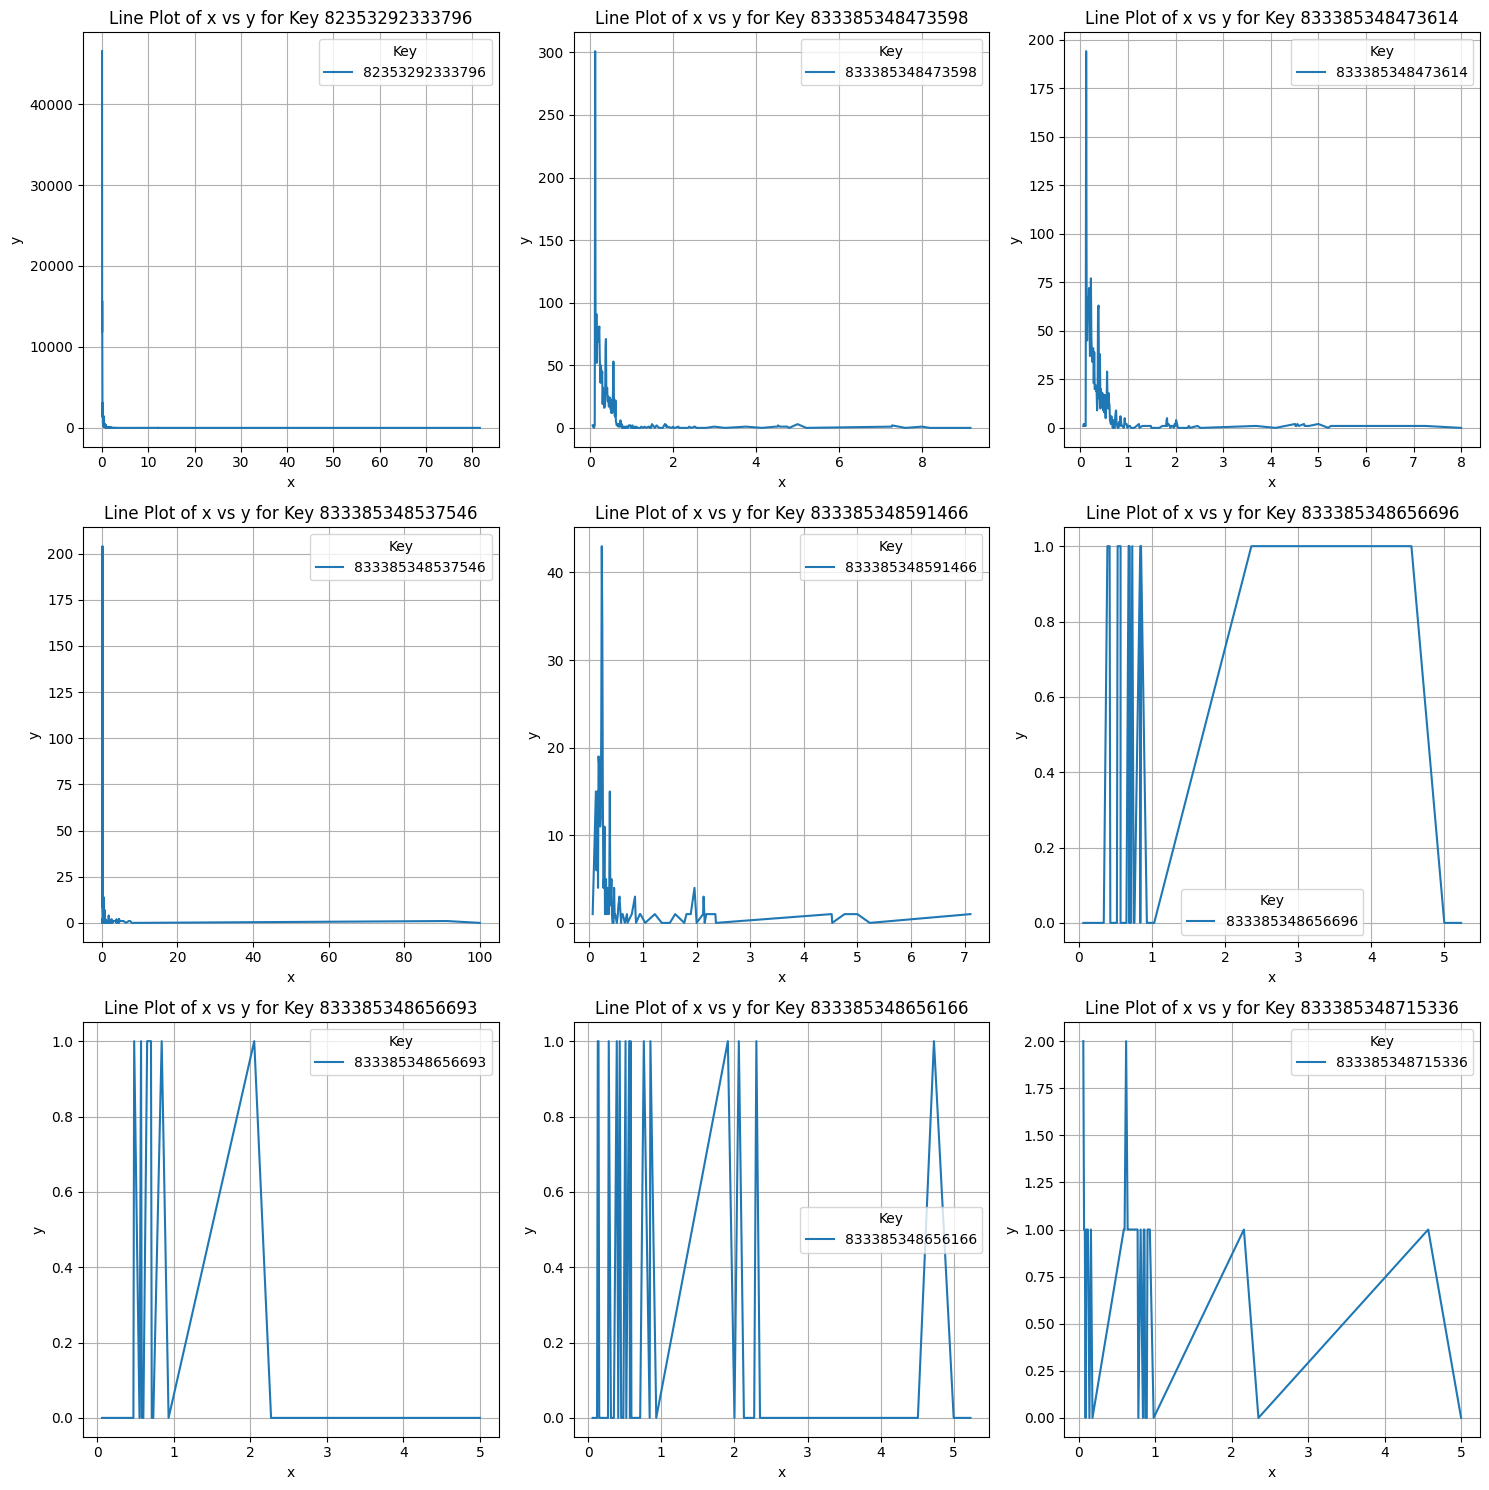

In [ ]:
# Select the multiple unique keys for visualization
num_keys = 9
sample_keys = df_raw['key'].unique()[:num_keys]

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

axes = axes.flatten()

for i, key in enumerate(sample_keys):
    filtered_group = df_raw[df_raw['key'] == key]
    sorted_group = filtered_group.sort_values(by='x')

    axes[i].plot(sorted_group['x'], sorted_group['y'], label=str(key))
    # axes[i].set_xlim(0, 6.2)
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('y')
    axes[i].set_title(f'Line Plot of x vs y for Key {key}')
    axes[i].legend(title='Key')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

The key groups have very distinct patterns: For example, among this 9 samples, we can observe long tail (Top Subplots), Bernoulli(Bottom Left and Middle Subplots), discrete uniform (Bottom Right Subplot), or unstable patterns with sudden jumps or irregular changes (Middle Subplot).

## On diminishing returns phenomenon and point

*Diminishing returns phenomenon* refers to the phenomenon where increase in x results in progressively smaller increases or even decreases in y.

*The point of diminishing returns* is the point beyond which adding more of x yields diminishing marginal gains in y.

We should be able to detect them by:
- A graph of rolling slope showing a decreasing trend in $\frac{dy}{dx}$, or
- Mathematically, the second derivative $\frac{d^2y}{dx^2}$, where it turns negative.

I noticed that y values are decreasing with the increasing x value, so the 'return' are negative. One **assumption** of this 'Inverse relationship' perhaps means that y represents a cost, error rate, or decay process instead of a benefit.

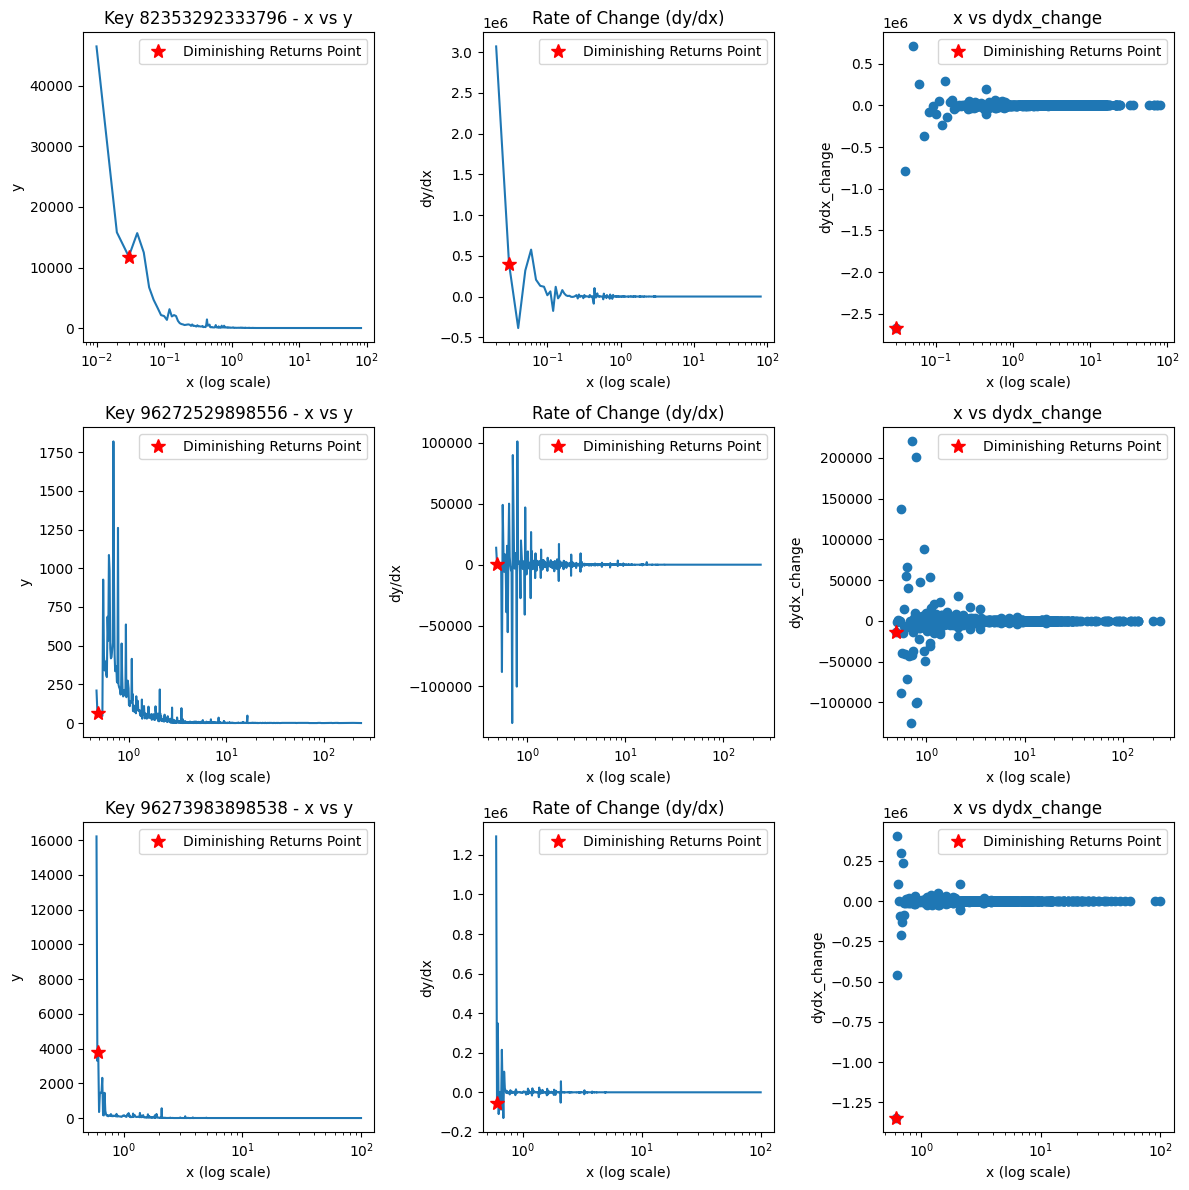

In [ ]:
# Recreate the visualization for a specific key value
df = df_raw.copy()

df.sort_values(by=['Key', 'x'], inplace=True)

df['dx'] = df.groupby('Key')['x'].diff()
df['dy'] = -1*df.groupby('Key')['y'].diff() # y value are decreasing when x increa, so y could be cost reduction
df['dydx'] = df['dy'] / df['dx']

df['dydx_change'] = df.groupby('Key')['dydx'].diff() # dy/dx starts decreasing should indicate the point of diminishing returns

sample_keys = df['Key'].unique()[:3]  # Select a few keys for visualization

fig, axes = plt.subplots(len(sample_keys), 3, figsize=(12, 4 * len(sample_keys)))

for i, key in enumerate(sample_keys):
    df_key = df[df['Key'] == key]

    diminishing_point = df_key[df_key['dydx_change'] < 0].iloc[0] if not df_key[df_key['dydx_change'] < 0].empty else None

    axes[i, 0].plot(df_key['x'], df_key['y'], linestyle='-')
    axes[i, 0].set_xscale('log')
    axes[i, 0].set_title(f"Key {key} - x vs y")
    axes[i, 0].set_xlabel("x (log scale)")
    axes[i, 0].set_ylabel("y")

    if diminishing_point is not None:
        axes[i, 0].plot(diminishing_point['x'], diminishing_point['y'], 'r*', markersize=10, label="Diminishing Returns Point")
        axes[i, 0].legend()

    axes[i, 1].plot(df_key['x'], df_key['dydx'], linestyle='-')
    axes[i, 1].set_xscale('log')
    axes[i, 1].set_title(f"Rate of Change (dy/dx)")
    axes[i, 1].set_xlabel("x (log scale)")
    axes[i, 1].set_ylabel("dy/dx")

    if diminishing_point is not None:
        axes[i, 1].plot(diminishing_point['x'], diminishing_point['dydx'], 'r*', markersize=10, label="Diminishing Returns Point")
        axes[i, 1].legend()

    # Plot dx vs dy with scatter plot
    axes[i, 2].scatter(df_key['x'], df_key['dydx_change'], marker='o')
    axes[i, 2].set_xscale('log')
    axes[i, 2].set_title(f"x vs dydx_change")
    axes[i, 2].set_xlabel("x (log scale)")
    axes[i, 2].set_ylabel("dydx_change")

    if diminishing_point is not None:
        axes[i, 2].plot(diminishing_point['x'], diminishing_point['dydx_change'], 'r*', markersize=10, label="Diminishing Returns Point")
        axes[i, 2].legend()

plt.tight_layout()
plt.show()

Based on the visualization, I have the following observations:

- The data points exhibit significant fluctuations, leading to abrupt shifts in the rate of change between positive and negative values. This is evident in the Rate of Change graphs for Key case 2, which show an initial jumpy pattern, and near x= 0.
- We can observe the general trend of decreasing $\frac{dy}{dx}$. See Rate of Change graphs, the magnitude of the Rate of Change gradually approaches zero as x increases.

Since these fluctuations we observed, **the previous method of finding the first occurrence where dydx_change becomes negative may not be reliable** due to initial noise or fluctuations.

I am thinking about these options we may apply to process the data:
- smoothing the data using rolling window before compute dydx_change, or
- look for a sustained decline over multiple points
- using some types of threshold

## Implementing Algorithm

My idea is:
1. Use smoothing method to reduce the impact of the sudden jumps and noise of the input. Here we choose Savitzky-Golay smoothing because
  - SG smoothing uses local polynomial fitting, meaning this filter fits a polynomial of a given order over each window. It provides a more accurate and stable first and second derivative than numerical differentiation on raw data.
2. Identify the point where $\frac{d^2y}{dx^2}$ approaches zero. Specifically, we can define a small threshold to detect near-zero second derivative.

*Note that this is a compromise, as the condition where $\frac{d^2y}{dx^2}$ approaches zero essentially identifies an inflection point (a point on the graph of a continuous function where the concavity changes), rather than the true point of diminishing returns.*

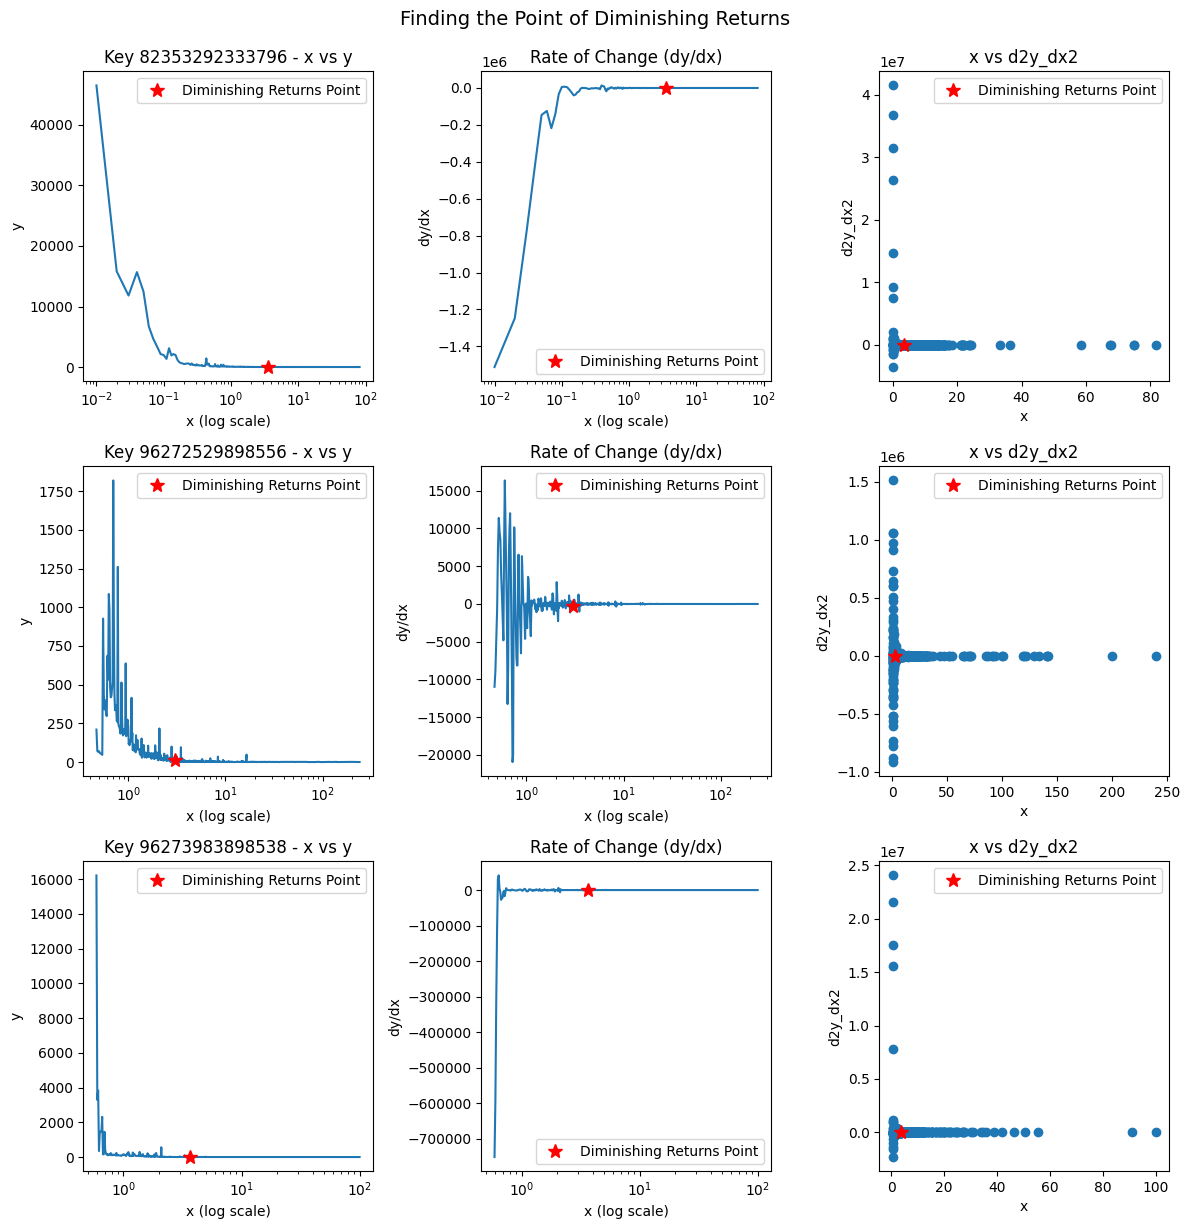

In [ ]:
df = df_raw.copy()
df.sort_values(by=['Key', 'x'], inplace=True)

sample_keys = df['Key'].unique()[:3]

fig, axes = plt.subplots(len(sample_keys), 3, figsize=(12, 4 * len(sample_keys)))

if len(sample_keys) == 1:
    axes = np.expand_dims(axes, axis=0)  # Ensure 2D indexing if only one key

for i, key in enumerate(sample_keys):
    df_key = df[df['Key'] == key].copy()

    window = min(10, len(df_key))  # Hyperparameter
    poly_order = 3 # Hyperparameter
    df_key['y_smooth'] = savgol_filter(df_key['y'], window_length=window, polyorder=poly_order) # Apply Savitzky-Golay filter for smoothing

    # Compute first and second derivatives
    df_key['dy_dx'] = np.gradient(df_key['y_smooth'], df_key['x'])
    df_key['d2y_dx2'] = np.gradient(df_key['dy_dx'], df_key['x'])
    # df_key['dx'] = np.gradient(df_key['x'])
    # df_key['dy'] = np.gradient(df_key['y'])

    # Identify the point where d²y/dx² approaches zero
    threshold = 1e-1  # Hyperparameter # use small threshold to detect near-zero second derivative
    diminishing_point = df_key[np.abs(df_key['d2y_dx2']) < threshold].head(1)

    axes[i, 0].plot(df_key['x'], df_key['y'], linestyle='-')
    axes[i, 0].set_xscale('log')
    axes[i, 0].set_title(f"Key {key} - x vs y")
    axes[i, 0].set_xlabel("x (log scale)")
    axes[i, 0].set_ylabel("y")

    if not diminishing_point.empty:
        axes[i, 0].plot(diminishing_point['x'], diminishing_point['y'], 'r*', markersize=10, label="Diminishing Returns Point")
        axes[i, 0].legend()

    axes[i, 1].plot(df_key['x'], df_key['dy_dx'], linestyle='-')
    axes[i, 1].set_xscale('log')
    axes[i, 1].set_title(f"Rate of Change (dy/dx)")
    axes[i, 1].set_xlabel("x (log scale)")
    axes[i, 1].set_ylabel("dy/dx")

    if not diminishing_point.empty:
        axes[i, 1].plot(diminishing_point['x'], diminishing_point['dy_dx'], 'r*', markersize=10, label="Diminishing Returns Point")
        axes[i, 1].legend()

    axes[i, 2].scatter(df_key['x'], df_key['d2y_dx2'], marker='o')
    axes[i, 2].set_title(f"x vs d2y_dx2")
    axes[i, 2].set_xlabel("x")
    axes[i, 2].set_ylabel("d2y_dx2")

    if not diminishing_point.empty:
        axes[i, 2].plot(diminishing_point['x'], diminishing_point['d2y_dx2'], 'r*', markersize=10, label="Diminishing Returns Point")
        axes[i, 2].legend()

plt.tight_layout()
plt.suptitle("Finding the Point of Diminishing Returns", fontsize=14, y=1.02)
plt.show()

Based on the right column (d2y_dx2) and middle column (dy_dx) subgraphs, we observe the identified diminishing returns points are moving closer to the location where 1st derivative stables and 2nd derivative becomes 0, in comparison with our 1st attampt. This looks promising.

Define this algorithm as function for automations:

In [ ]:
def find_diminishing_return(df, threshold=1e-1, window_size=10, poly_order=3):
    """
    This algorithm detects the point of diminishing return for each Key in the dataset.

    Inputs:
    - df: a dataframe with columns ['Key', 'x', 'y'].
    - threshold: sensitivity for detecting near-zero second derivative.
    - window_size: window length used in smoothing.
    - poly_order: polynomial order used in smoothing.

    Outputs:
    - pdr_df: Dataframe containing the detected PDR points for each Key.
    """

    df.sort_values(by=['Key', 'x'], inplace=True)
    keys = df['Key'].unique()

    pdr_list = []

    for key in keys:
        df_key = df[df['Key'] == key].copy()

        if len(df_key) < window_size:
            window_size = len(df_key)

        df_key['y_smooth'] = savgol_filter(df_key['y'], window_length=window_size, polyorder=poly_order)

        with np.errstate(divide='ignore', invalid='ignore'):
          df_key['dy_dx'] = np.gradient(df_key['y_smooth'], df_key['x'])
          df_key['d2y_dx2'] = np.gradient(df_key['dy_dx'], df_key['x'])
          pdr_point = df_key[np.abs(df_key['d2y_dx2']) < threshold].head(1)

        if not pdr_point.empty:
            pdr_list.append({
                'Key': key,
                'x_pdr': pdr_point['x'].values[0],
                'y_pdr': pdr_point['y'].values[0],
                'dy_dx_pdr': pdr_point['dy_dx'].values[0],
                'd2y_dx2_pdr': pdr_point['d2y_dx2'].values[0]
            })

    pdr_df = pd.DataFrame(pdr_list)

    return pdr_df

This is lazy learning algorithm so it perform computations during the query time. THere's no explicit training phase.


In [ ]:
# Test
df = df_raw.copy()
pdr_results = find_diminishing_return(df)

In [ ]:
pdr_results.head()

,Key,x_pdr,y_pdr,dy_dx_pdr,d2y_dx2_pdr
0,82353292333796,3.59,2,11.562500,1.189164e-10
1,96272529898556,3.00,10,-224.375000,-3.637979e-11
2,96273983898538,3.67,0,-11.875000,2.683009e-11
3,96273983898544,5.97,1,-26.250000,4.297362e-11
4,96273983898546,34.90,1,0.097807,9.147951e-03


## Evaluation of the performance

### Computational Performance Evaluation

The theoretical time and space complexity should be:
- Time complexity: O(NlogN)+O(KM), where N is the total number of rows in the input data and M is the number of rows for a given Key, K be the number of unique keys.
- Space Complexity: O(N) (storing original data)

This should be efficient for large datasets as long as sorting is optimized.

In [ ]:
# Measure execution time
df = df_raw.copy()

start_time = time.time()
pdr_results = find_diminishing_return(df)
end_time = time.time()
execution_time = end_time - start_time

print(f"Execution Time: {execution_time:.4f} seconds")

# Measure memory usage
mem_usage = memory_profiler.memory_usage((find_diminishing_return, (df,)))
print(f"Memory Usage: {max(mem_usage):.2f} MB")

Execution Time: 0.6083 seconds
Memory Usage: 331.23 MB


### Sensitivity Test

In [ ]:
thresholds = [0.5, 1e-1, 1e-2]
window_sizes = [5, 10, 20]

for w in window_sizes:
    for t in thresholds:
        print(f"Running with threshold={t}, window_size={w}")
        pdr_results = find_diminishing_return(df_raw, threshold=t, window_size=w)
        print(pdr_results.head())

Running with threshold=0.5, window_size=5
              Key  x_pdr  y_pdr     dy_dx_pdr   d2y_dx2_pdr
0  82353292333796   2.96     11 -2.057143e+02 -5.456968e-12
1  96272529898556   6.84      1  0.000000e+00  3.552714e-13
2  96273983898538   5.26      1  1.285714e+01 -4.263256e-13
3  96273983898544   5.23     10 -1.142857e+02 -9.240466e-10
4  96273983898546  10.93      1 -4.440892e-15 -1.480297e-13
Running with threshold=0.1, window_size=5
              Key  x_pdr  y_pdr     dy_dx_pdr   d2y_dx2_pdr
0  82353292333796   2.96     11 -2.057143e+02 -5.456968e-12
1  96272529898556   6.84      1  0.000000e+00  3.552714e-13
2  96273983898538   5.26      1  1.285714e+01 -4.263256e-13
3  96273983898544   5.23     10 -1.142857e+02 -9.240466e-10
4  96273983898546  10.93      1 -4.440892e-15 -1.480297e-13
Running with threshold=0.01, window_size=5
              Key  x_pdr  y_pdr     dy_dx_pdr   d2y_dx2_pdr
0  82353292333796   2.96     11 -2.057143e+02 -5.456968e-12
1  96272529898556   6.84      1  

This is for testing how hyperparameters impact results by running the algorithm with different grid of hyperparameters. We observe that (*This is only naive observation based on these shown groups, further investigation is needed. Also poly order hyperparameter is not tested.*):

- The window_size impacts the estimated output drastically, the general trend is that larger window_size moves the estimated output further on the tail.
- Threshold doesn't really impact the output when window_size is small (window_size <= 10)

### Accuracy/Visual Inspection (Manual validation)

In [ ]:
def evaluate_performance(df_raw, pdr_results, num_keys_to_visualize=5):
    """
    Evaluates the performance of the diminishing returns algorithm.

    Inputs:
        - df_raw: Original DataFrame.
        - pdr_results: DataFrame of detected PDR points.
        - num_keys_to_visualize: Number of keys to visualize.

    Outputs:
        - None (displays evaluation results).
    """

    # Visual Inspection
    sample_keys = df_raw['Key'].unique()[:num_keys_to_visualize]
    for key in sample_keys:
        plt.figure(figsize=(10, 6))
        key_data = df_raw[df_raw['Key'] == key].sort_values('x')
        plt.plot(key_data['x'], key_data['y'], linestyle='-')

        pdr_point = pdr_results[pdr_results['Key'] == key]
        if not pdr_point.empty:
            plt.scatter(pdr_point['x_pdr'], pdr_point['y_pdr'], color='red', marker='*',s=100, label='Detected PDR Point')

        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(f'Diminishing Returns for Key {key}')
        plt.legend()
        plt.show()

    # Quantitative metrics (or metrics depending on what makes sense in the business context)
    # for example: calculate the mean absolute error between predicted and ground truth, if ground truth for the diminishing returns point is provided.

    print("\nSummary of Detected Diminishing Returns Points:")
    print(pdr_results)
    number_of_detected_points = pdr_results.shape[0]
    total_keys = df_raw['Key'].nunique()
    print(f"\nThe number of detected points are {number_of_detected_points}, out of total keys {total_keys} in the dataset.")

In [ ]:
# df = df_raw.copy()
# pdr_results = find_diminishing_return(df)

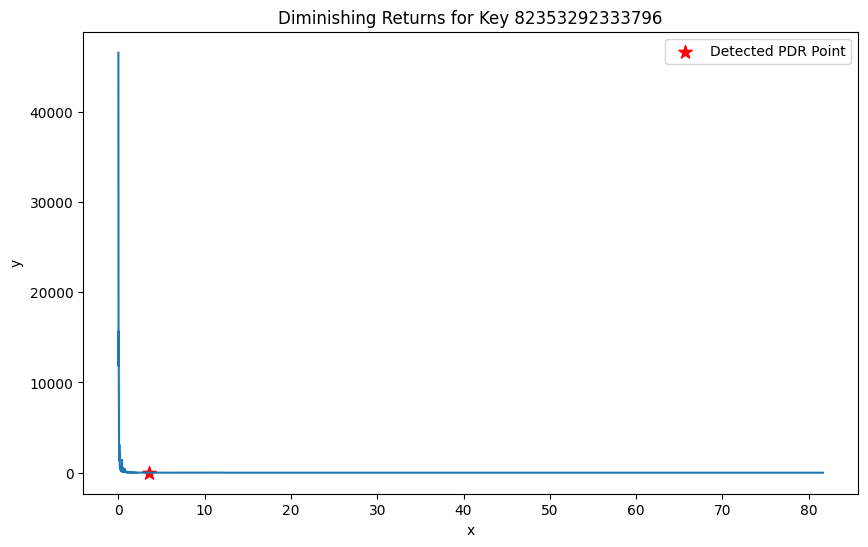

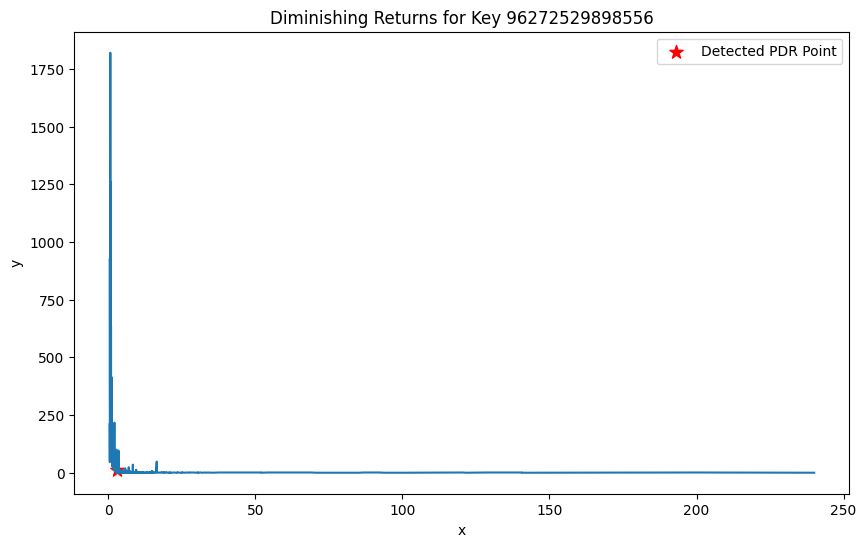

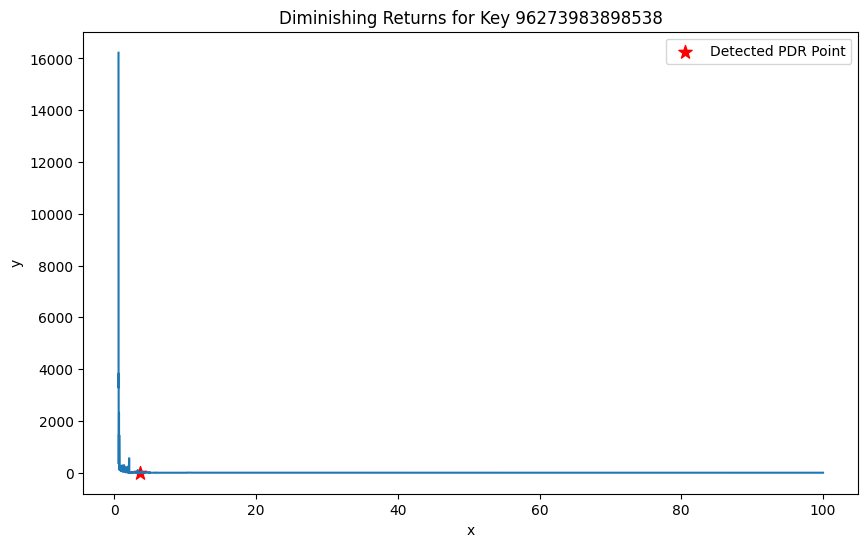

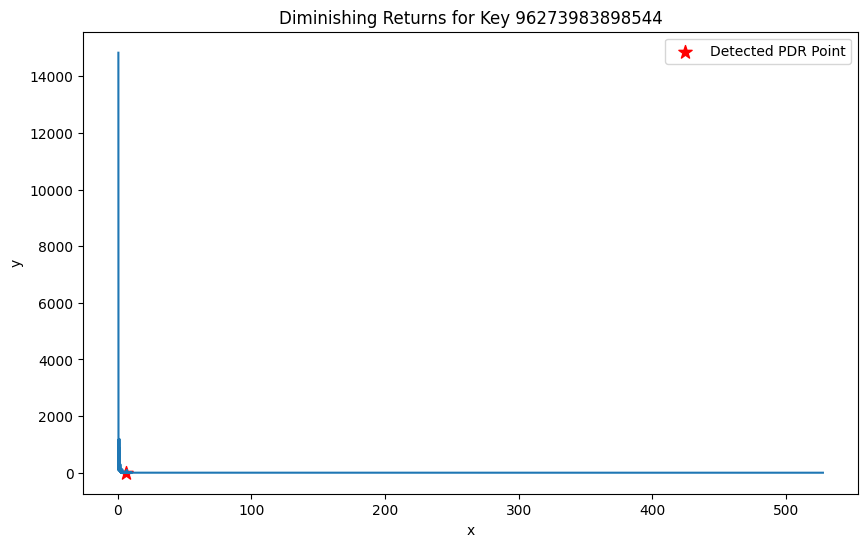

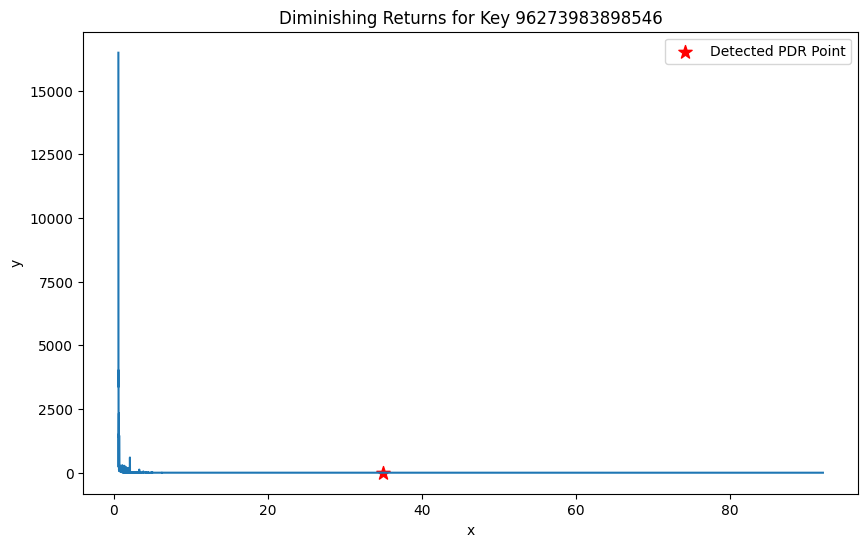


Summary of Detected Diminishing Returns Points:
                   Key  x_pdr  y_pdr   dy_dx_pdr   d2y_dx2_pdr
0       82353292333796   3.59      2   11.562500  1.189164e-10
1       96272529898556   3.00     10 -224.375000 -3.637979e-11
2       96273983898538   3.67      0  -11.875000  2.683009e-11
3       96273983898544   5.97      1  -26.250000  4.297362e-11
4       96273983898546  34.90      1    0.097807  9.147951e-03
..                 ...    ...    ...         ...           ...
155  34222348628764300   9.04      1   40.952381  2.537490e-10
156  35382335794646300  10.02      6  -47.142857 -3.183231e-12
157  35382338926533700   1.64      2 -137.142857  3.183231e-11
158  35382347368695600   4.68      0  -32.857143 -6.356820e-11
159  37262356796747504   4.63      0    5.714286  5.258016e-12

[160 rows x 5 columns]

The number of detected points are 160, out of total keys 173 in the dataset.


In [ ]:
evaluate_performance(df_raw, pdr_results, num_keys_to_visualize=5)

On visual inspection of the experiment results, we find this algorithm:
- Finds the diminishing points where y starts to become stable in value
- May not find diminishing points for some group, there are 13 groups' points are not identified. *The reason could be data has discrete distribtion, but needs further investigation.*

**Strengths of the Algorithm**:
- It works well with noisy data because smoothing process
- Smoothing also ensures more reliable derivatives and detects real trends in y instead of random fluctuations.
- Hyperparameters (window_size, threshold, poly_order) allow tuning for different types of diminishing return trends. Users can manually adjust hyperparameters if they notice inconsistencies in results.
- Uses gradient-based detection, which naturally ignores isolated high-variance points.

**Limitations of the Algorithm**:
- The choice of hyperparameters significantly impacts results. In fact, Bad hyperparameters can lead to: Missing the correct point (if the threshold is too high); False positives (detecting point too early); Over-smoothing, leading to loss of finer details.
  - If we have ground truth PDR data, a potential solution is to automate hyperparameter tuning using Bayesian Optimization or grid search.
- Sparse inputs will cause trouble for this algorithm too, becuase large gaps between x values lead to unstable second derivatives.
  - a potential solution is to apply interpolation before computing derivatives in this scenario.
- Due to time limit, I haven't optimized the memory usage for this algorithm.
  - Further cahce optimization is needed.

## Some of other ideas & Test

### Idea 1: Fitting model with analytical solution

Given the observed skewed distribution within the groups, one idea is fitting a model that has an analytical solution for the point where its second derivative equals zero. This way, we can directly compute the estimated model parameters and derive the analytical solution.

Note that this won't work for the groups with discrete distributions like we observed from EDA section like Bernoulli shapes or discrete uniform shapes x-y relationship.

Here we try to use a flipped logarithmic function to reflect the downward trend of the long-tail pattern from some key groups.

In [ ]:
def decreasing_log_model(x, a, b, c):
    return a - b * np.log(x + c)

def find_pdr_log_fit(df):
    df.sort_values(by=['Key', 'x'], inplace=True)
    keys = df['Key'].unique()

    pdr_list = []

    for key in keys:
        df_key = df[df['Key'] == key].copy()

        min_x = df_key['x'].min()
        shift_c = -min_x + 1e-6 if min_x <= 0 else 0 # Ensure x > 0 (Shift if needed)

        try:
            popt, _ = curve_fit(decreasing_log_model, df_key['x'] + shift_c, df_key['y'], maxfev=5000)
            a, b, c = popt
        except RuntimeError:
            print(f"Warning: Could not fit model for Key {key}")
            continue

        x_values = df_key['x'].values
        d2y_dx2 = -b / ((x_values + c + shift_c) ** 2) # Compute analytical second derivative: d²y/dx² = -b / (x + c)²

        threshold = 1e-3  # need to tune
        diminishing_idx = np.where(np.abs(d2y_dx2) < threshold)[0]

        if len(diminishing_idx) > 0:
            x_pdr = x_values[diminishing_idx[0]]
            y_pdr = decreasing_log_model(x_pdr, *popt)

            pdr_list.append({
                'Key': key,
                'x_pdr': x_pdr,
                'y_pdr': y_pdr,
                'd2y_dx2_pdr': d2y_dx2[diminishing_idx[0]]
            })

    pdr_df = pd.DataFrame(pdr_list)
    return pdr_df

In [ ]:
df = df_raw.copy()
pdr_results = find_pdr_log_fit(df)

pdr_results.head()

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Key,x_pdr,y_pdr,d2y_dx2_pdr
0,82353292333796,33.35,-2.675007,-0.000988
1,96272529898556,35.46,-1.924559,-0.001000
2,96273983898538,33.95,-2.477322,-0.000964
3,96273983898544,33.52,-2.344409,-0.000936
4,96273983898546,34.19,-2.450851,-0.000939


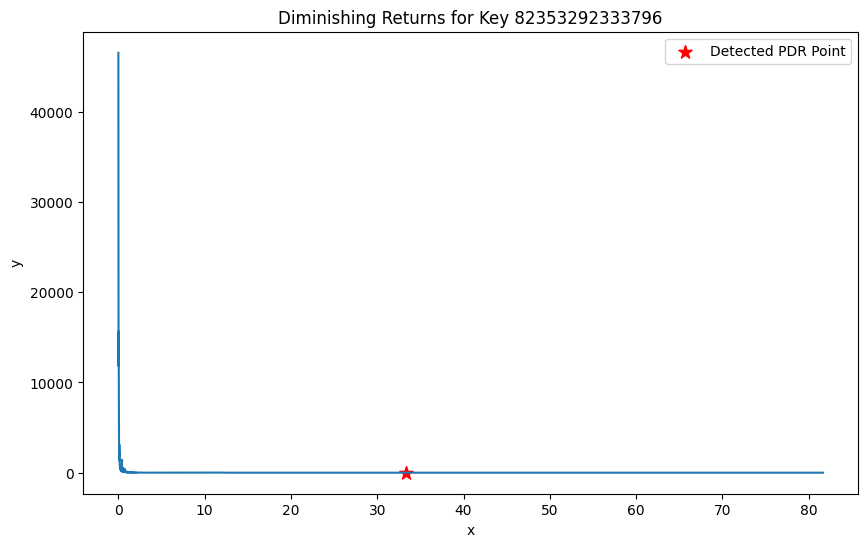

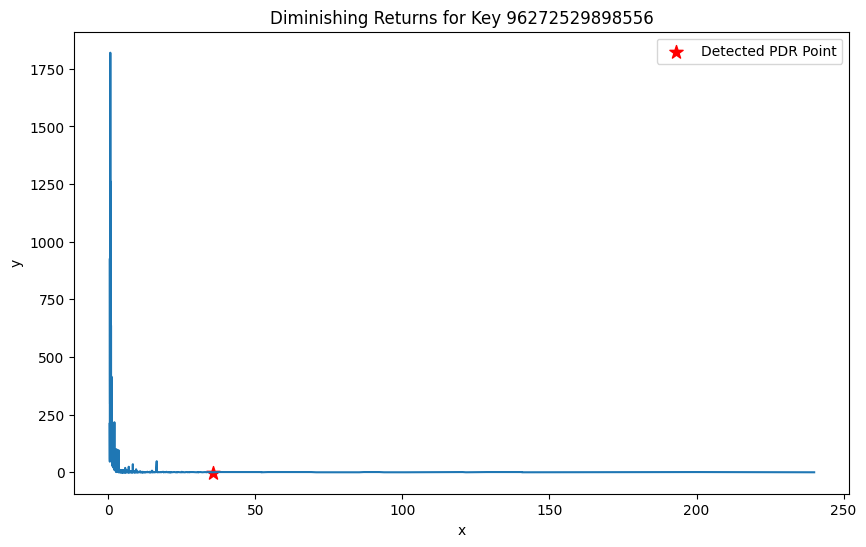

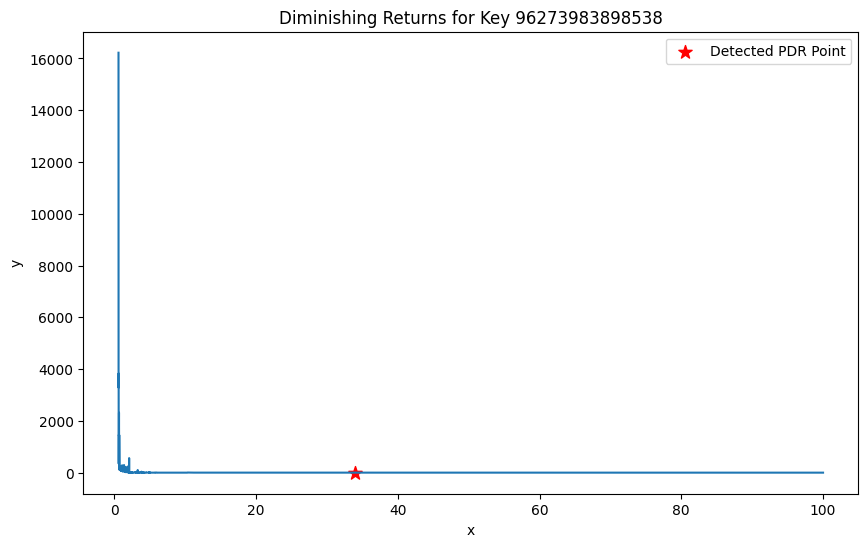

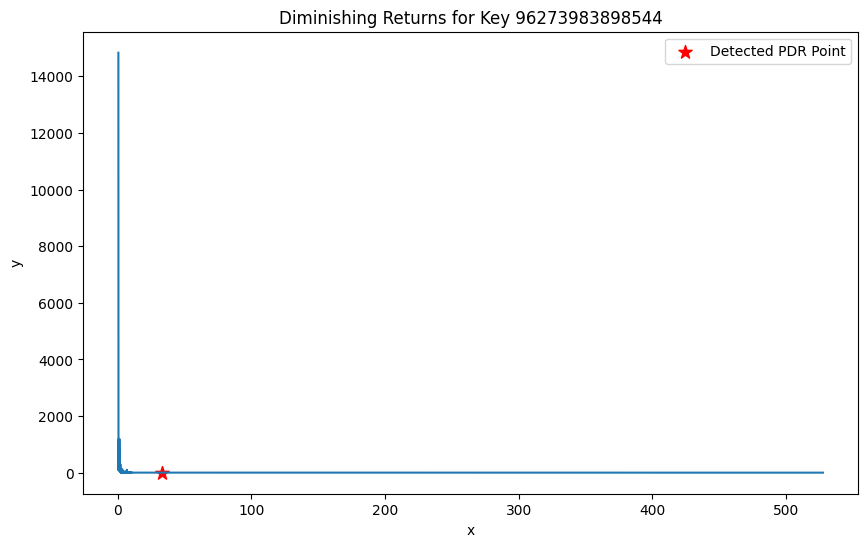

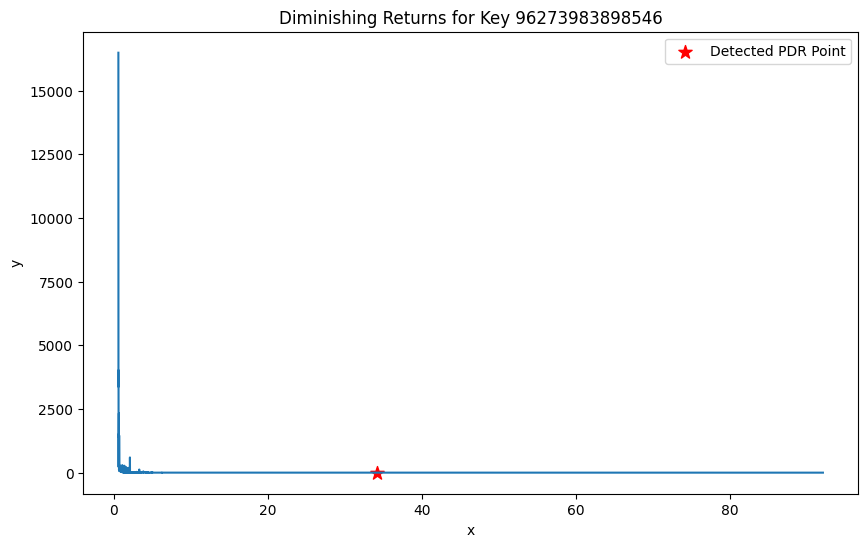


Summary of Detected Diminishing Returns Points:
                   Key  x_pdr     y_pdr  d2y_dx2_pdr
0       82353292333796  33.35 -2.675007    -0.000988
1       96272529898556  35.46 -1.924559    -0.001000
2       96273983898538  33.95 -2.477322    -0.000964
3       96273983898544  33.52 -2.344409    -0.000936
4       96273983898546  34.19 -2.450851    -0.000939
..                 ...    ...       ...          ...
120  33926343638666600  55.38 -2.797703    -0.000389
121  34222348628764300  34.43 -2.139064    -0.000873
122  35382335794646300  32.30 -2.354965    -0.000989
123  35382347368695600  38.81 -3.525705    -0.000896
124  37262356796747504  37.36 -2.760430    -0.000845

[125 rows x 4 columns]

The number of detected points are 125, out of total keys 173 in the dataset.


In [ ]:
evaluate_performance(df_raw, pdr_results, num_keys_to_visualize=5)

This clearly needs some more modifications...

### Idea 2: find the change point of rate of change

Transform into a time-series change-point problem, we may consider using statistical change detection to find where the rate of change (1st derivative) significantly drops.
- Compute the rolling average of dy/dx over a window.
- Run tests like Bayesian Change-Point Detection

...to be implemented

## Business metric discussion

Diminishing Returns Problems are critical considerations in business because they help determine the optimal allocation of resources, particularly in preventing over-spending where additional investment yields diminishing returns.

For example, in marketing and advertising, it can help to decide on how much should be spent on advertising before additional spending stops being effective; In traffic engineering, it can also help analyze the impact of adding more lanes to a road—after a certain point, additional lanes do not significantly reduce congestion due to induced demand; In supply chain management, it can help answer how much inventory should be stocked before holding costs outweigh sales benefits, etc.

In summary, I think this concept important mainly because it can help make data-driven decisions regarding:

- Avoiding Resource Waste: Businesses often allocate budgets/resources without clear optimization. So Detecting diminishing returns prevents overspending on areas with little impact.

- Maximizing Profitability: By identifying the points of diminishing Return, businesses can stop unnecessary spending and allocate funds to higher-impact areas.


